In [44]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
# Helper
def display_results(problem, w, constraints):
    print(f"Status: {problem.status}")
    print(f"Optimal Value: {problem.value:.4f}")
    print(f"Weights: {np.round(w.value, 4)}")
    print("Dual Values (Lagrange multipliers):")
    for i, c in enumerate(constraints, 1):
        if c.dual_value is not None:
             print(f"Constraint {i}: {np.round(c.dual_value, 4)}")
        else:
             print("None")

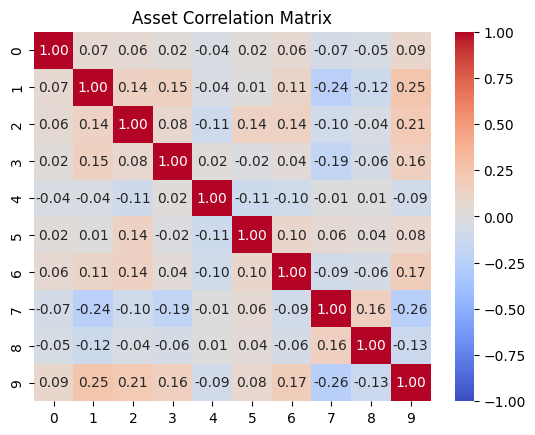

In [98]:
def generate_synthetic_data(N=10, random_seed=42):
    """
    Generates synthetic returns and a covariance matrix.
    Uses a factor model structure to ensure realistic correlation.
    """
    np.random.seed(random_seed)

    # Generate mean random returns between -5% and 15%
    mu = np.random.uniform(-0.05, 0.15, N)

    # Generate Covariance Matrix using a Factor Model
    n_factors = 3
    B = np.random.normal(loc=0, scale=0.15, size=(N, n_factors)) # Factor loading
    # Systematic (Factor) Variance
    F_cov = np.diag(np.random.uniform(0.1, 0.3, n_factors)) # Assume orthogonal factors --> diagonal factor covariance matrix
    # Idiosyncratic variances
    D = np.diag(np.random.uniform(0.05, 0.1, N)) # Increase Idiosyncratic Variance to lower correlation
    C = B @ F_cov @ B.T + D
    C = (C + C.T) / 2 # Ensure C is symmetric (floating point fix)
    return mu, C

# Usage
N = 10
mu, C = generate_synthetic_data(N = N)
assert all(np.linalg.eigvalsh(C) > 0)

std_devs = np.sqrt(np.diag(C))
corr_matrix = C / np.outer(std_devs, std_devs)

sns.heatmap(corr_matrix, 
            annot=True,
            fmt=".2f", 
            cmap='coolwarm',
            vmin=-1, vmax=1)

plt.title("Asset Correlation Matrix")
plt.show()

# Base Cases
$$\begin{aligned}
& \min_w \quad w^T C w \\
& \text{s.t.} \quad \mathbf{1}^T w = 1
\end{aligned}$$

In [118]:
w = cp.Variable(N)
constraints = [cp.sum(w) == 1]
objective = cp.Minimize(cp.quad_form(w, C))
problem = cp.Problem(objective, constraints)
problem.solve()

display_results(problem, w, constraints)

Status: optimal
Optimal Value: 0.0087
Weights: [0.0903 0.0682 0.0457 0.0913 0.1157 0.1056 0.1095 0.1731 0.1254 0.0751]
Dual Values (Lagrange multipliers):
Constraint 1: -0.0174



$$\begin{aligned}
\min_{w} \quad & w^T C w \\
\textrm{s.t.} \quad & \mathbf{1}^T w = 1 \\
& w \geq 0
\end{aligned}$$

In [119]:
w = cp.Variable(N)
constraints = [cp.sum(w) == 1, w >= 0]
objective = cp.Minimize(cp.quad_form(w, C))
problem = cp.Problem(objective, constraints)
problem.solve()
display_results(problem, w, constraints)

Status: optimal
Optimal Value: 0.0087
Weights: [0.0903 0.0682 0.0457 0.0913 0.1157 0.1056 0.1095 0.1731 0.1254 0.0751]
Dual Values (Lagrange multipliers):
Constraint 1: -0.0174
Constraint 2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Markowitz Efficient Frontier
$$\begin{aligned}
\min_{w} \quad & w^T C w \\
\textrm{s.t.} \quad & \mu^T w \geq R_{target} \\
& \mathbf{1}^T w = 1 \\
& w \geq 0
\end{aligned}$$

In [121]:
w = cp.Variable(N)
target_return = cp.Parameter()

constraints = [cp.sum(w) == 1, w >= 0, mu @ w >= target_return]
objective = cp.Minimize(cp.quad_form(w, C))
problem = cp.Problem(objective, constraints)

target_values = np.linspace(0, mu.max(), 5)
results = []
print(f"{'Target':<10} | {'Risk (Std)':<10} | {'Status':<10}")
print("-" * 35)

for val in target_values:
    target_return.value = val
    try:
        problem.solve()
        if problem.status == 'optimal':
            risk_val = np.sqrt(problem.value)
            print(f"{val:.4f}     | {risk_val:.4f}     | {problem.status}")
        else:
            print(f"{val:.4f}     | {'N/A':<10} | {problem.status}")
    except:
         print(f"{val:.4f}     | {'Err':<10} | Error")

Target     | Risk (Std) | Status    
-----------------------------------
0.0000     | 0.0932     | optimal
0.0350     | 0.0932     | optimal
0.0701     | 0.0969     | optimal
0.1051     | 0.1222     | optimal
0.1401     | 0.3498     | optimal


# Transaction Costs

$$\begin{aligned}
& \min_{w, z} \quad w^T C w \\
& \text{s.t.} \quad \mathbf{1}^T w = 1, \quad w \ge 0 \\
& \quad \quad \sum z \le K \\
& \quad \quad w_i \le z_i \quad \forall i \\
& \quad \quad z_i \in \{0, 1\}
\end{aligned}$$